# Introduzione  
In questo notebook si testano le modifiche della funzione di o3d per cercare d inserire un concetto di distanza dal piano per grafi

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
import pyvista as pv

In [15]:
# point_cloud = np.loadtxt('data/bunny_fine.txt', delimiter=",", skiprows=1)           # without normals
# pcd = o3d.geometry.PointCloud()
# pcd.points = o3d.utility.Vector3dVector(point_cloud[:,:3])

## Set lambda and cos_alpha_tresh 

In [95]:
# true normals:
#point_cloud_normals = np.loadtxt('sphere_normals.txt', delimiter=",", skiprows=1)           # sphere with normals
lamb = 0
cosa = 1

point_cloud_normals = np.loadtxt('bunny_norm_new.txt', delimiter=",", skiprows=1)           # bunny with normals

pcd_norm = o3d.geometry.PointCloud()
pcd_norm.points = o3d.utility.Vector3dVector(point_cloud_normals[:,3:6])
pcd_norm.normals = o3d.utility.Vector3dVector(point_cloud_normals[:,:3])

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(point_cloud_normals[:,3:6])

pcd.estimate_normals()
pcd.orient_normals_consistent_tangent_plane(9, lamb, cosa) #knn, lambda, cosalpha            # 100 for sphere, 11 for bunny


# est_normals = np.asarray(pcd.normals)
# est_normals = - est_normals

# pcd.normals = o3d.utility.Vector3dVector(est_normals)

Procedo con tangenti NUOVE open3D


In [96]:
# Animation callback function. it needs to contain as a minimum the visualizer reference
def rotate_around(vis):
    # We create a 3D rotation matrix from x,y,z rotations, the rotations need to be given in radians
    R = mesh.get_rotation_matrix_from_xyz((0,0,  np.deg2rad(1)))
    # The rotation matrix is applied to the specified object - in our case the mesh. We can also specify the rotation pivot center
    mesh.rotate(R, center=np.mean(mesh.vertices,0))

    # We create a 3D rotation matrix for the sphere as well in the opposite direction
    R_sphere = mesh.get_rotation_matrix_from_xyz((0, np.deg2rad(-4), 0))
    # Apply it
    sphere_mesh.rotate(R_sphere, center=(0, 0, 0))
    # For the changes to be seen we need to update both the geometry that has been changed and to update the whole renderer connected to the visualizer
    vis.update_geometry(mesh)
    vis.update_geometry(sphere_mesh)
    vis.update_renderer()



#print(o3d._version_)

# Load mesh, together with setting the flag for post-processing to True, so the texture and material will be loaded
mesh_path = "bunny_norm_new.txt"   #'mesh/angelStatue_lp.obj'
mesh = poisson_mesh
mesh.paint_uniform_color([0.9, 0.5, 0.2])
mesh.compute_vertex_normals()

print(mesh)
print('Vertices:')
print(np.asarray(mesh.vertices))
print('Triangles:')
print(np.asarray(mesh.triangles))


# We can extract information from the mesh like faces, UVs and texture
mesh_faces = mesh.triangles
mesh_uvs = mesh.triangle_uvs
texture = mesh.textures



# We create a visualizer object that will contain references to the created window, the 3D objects and will listen to callbacks for key presses, animations, etc.
vis = o3d.visualization.Visualizer()
# New window, where we can set the name, the width and height, as well as the position on the screen
vis.create_window(window_name='Title', width=800, height=600)

# We call add_geometry to add a mesh or point cloud to the visualizer
vis.add_geometry(mesh)

# We can easily create primitives like cubes, sphere, cylinders, etc. In our case we create a sphere and specify its radius
sphere_mesh = o3d.geometry.TriangleMesh.create_sphere(radius=0.05)

# We can compute either vertex or face normals
sphere_mesh.compute_vertex_normals()
# Add the sphere to the visualizer
vis.add_geometry(sphere_mesh)
# Translate it from the center
sphere_mesh.translate((1, 0, 0))

#Initial rotation
R = mesh.get_rotation_matrix_from_xyz((0, 0, 0)) #x = -np.deg2rad(60)
mesh.rotate(R, center=(0, 0, 20))
vis.update_geometry(mesh)
vis.update_geometry(sphere_mesh)
vis.update_renderer()

# We can register callback animation functions that will be run on every update cycle
vis.register_animation_callback(rotate_around)
# We run the visualizater
vis.run()
# Once the visualizer is closed destroy the window and clean up
vis.destroy_window()

TriangleMesh with 10990 points and 21976 triangles.
Vertices:
[[-1.43067337e+01  1.28481382e+01  9.30595398e-03]
 [-1.07152746e+01 -1.30846146e+01  9.30595398e-03]
 [-1.44915534e+01  1.28678166e+01  9.30595398e-03]
 ...
 [-1.08719308e+01 -7.97650596e+00  4.94012604e+01]
 [-1.14911568e+01 -8.61773325e+00  4.95645866e+01]
 [-1.27516101e+01 -8.63973455e+00  4.95714264e+01]]
Triangles:
[[  354   273   333]
 [  329   273   354]
 [   67   329   354]
 ...
 [10745 10765 10746]
 [10606 10607 10677]
 [10677 10721 10606]]


[135.7696152192135, 31.52316264680024, 50.32996062163111, 161.5372016515883, 152.09845341085057, 162.02924428645585, 143.76761820760612, 140.11215121833456, 145.30544131547904, 126.98339331433968, 128.46752193454287, 86.76350565721458, 10.55584991046028, 5.288492100784129, 10.511405101816603, 9.702317968158805, 4.0051416488698175, 5.156960803044432, 10.479160959940003, 19.81167305086877, 163.04184990472362, 19.905176388624206, 14.402095178651713, 17.406079697342186, 156.08621509438993, 149.9436268690784, 154.52027419402106, 141.66403028272677, 151.56510105160234, 148.63388534939278, 5.201542841753469, 1.5291206305085057, 19.17708698956475, 21.021546457991214, 23.76283874439748, 22.76150551466477, 17.53077854883707, 38.513812936371416, 21.828839931691704, 18.708848544303127, 10.72605263740372, 14.210480717404177, 16.29768280791954, 11.807802988125747, 9.805469910934043, 6.411533992087166, 9.579251797633896, 171.2486753119093, 174.45036967676984, 175.05785405250768, 138.4716639893401, 13

{'whiskers': [<matplotlib.lines.Line2D at 0x7f411455cee0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f413b781dc0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f41243fc880>],
 'medians': [<matplotlib.lines.Line2D at 0x7f412414ec70>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f413b8ecd90>],
 'means': []}

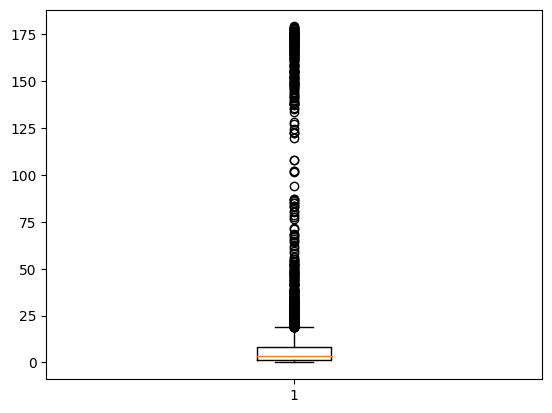

In [97]:
error_angle = []

for i in range(point_cloud_normals.shape[0]):
    scalar_prod = 0.0
    vec1 = 0.0
    vec2 = 0.0
    for k in range(3):
        scalar_prod += pcd.normals[i][k] * pcd_norm.normals[i][k]
    vec1 = np.sqrt(np.sum(pcd.normals[i]**2))           # estimated
    vec2 = np.sqrt(np.sum(pcd_norm.normals[i]**2))      # true
    alpha = np.arccos(scalar_prod / (vec1 * vec2)) / 3.14 * 180
    
    error_angle.append(alpha)

print(error_angle) 
norm_error = np.sum(error_angle) / point_cloud_normals.shape[0]
print("average error", norm_error)
print("max error", np.max(error_angle))
print("min error", np.min(error_angle))

plt.boxplot(error_angle)

In [6]:
len(pcd.points)

6901

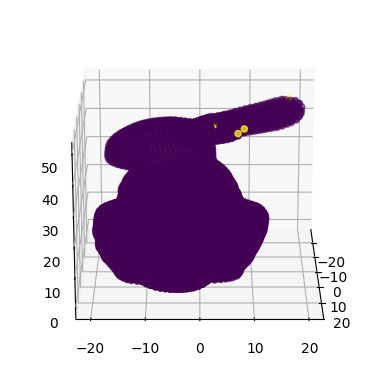

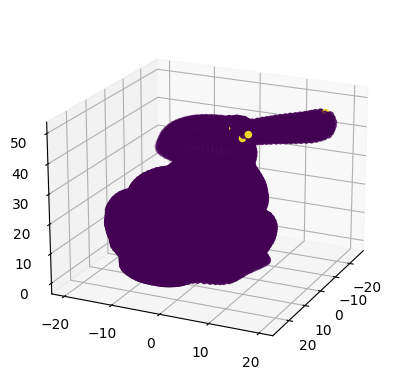

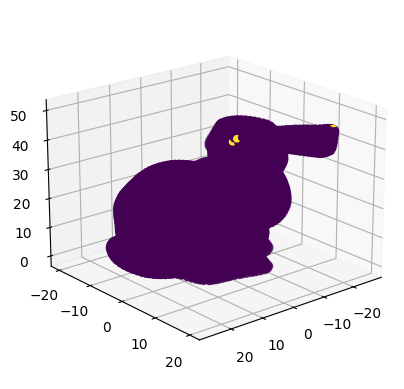

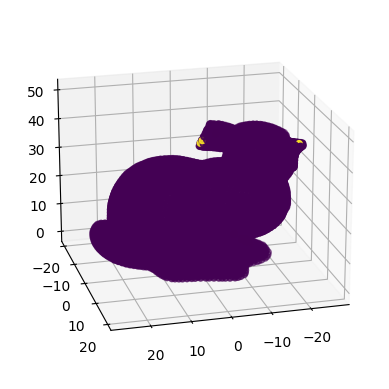

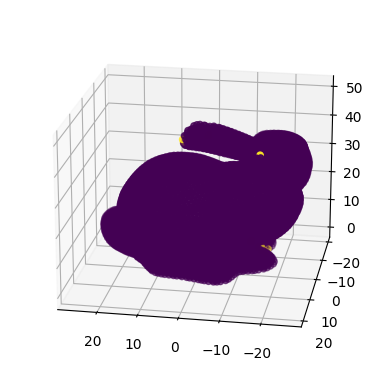

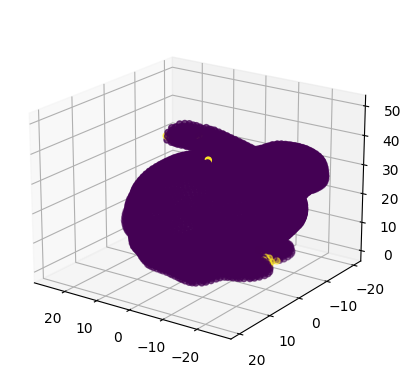

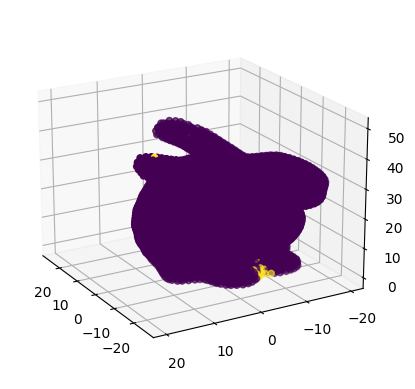

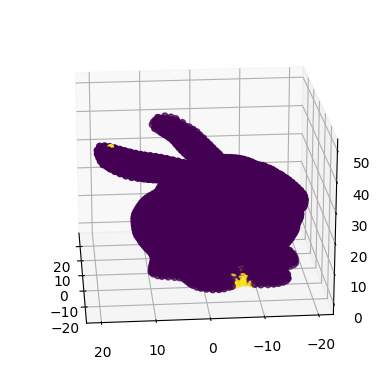

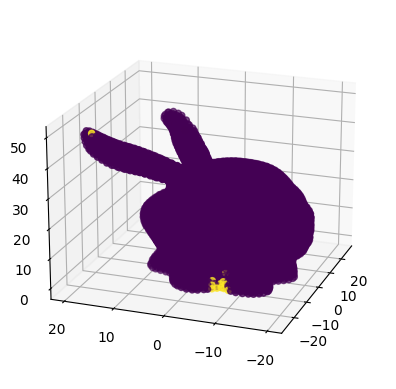

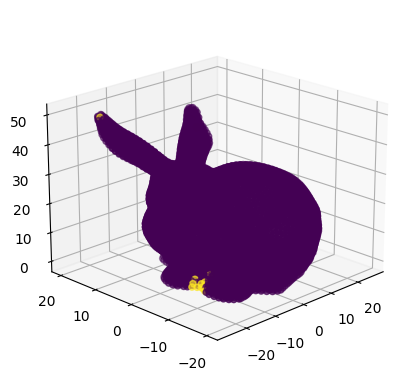

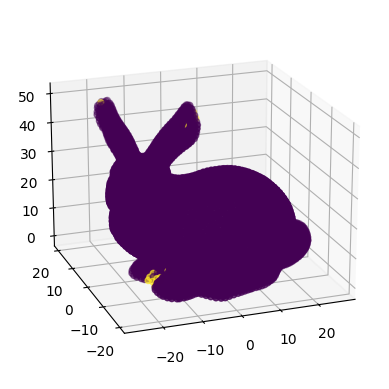

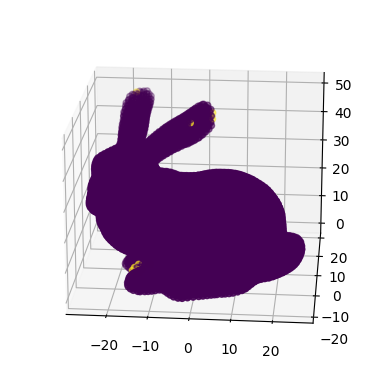

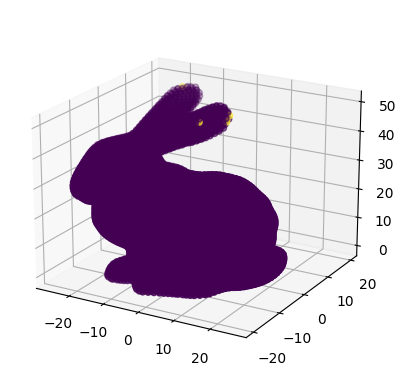

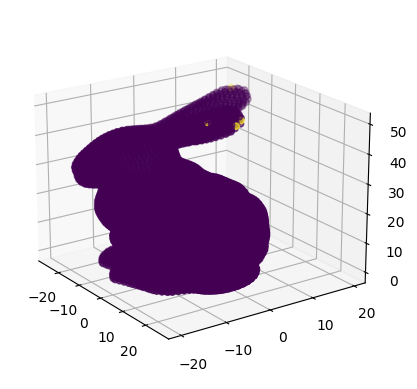

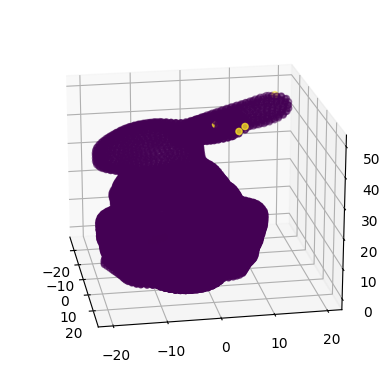

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image

idx = np.where(np.asarray(error_angle) > 90)
colors = np.zeros(len(error_angle))
colors[idx] = 1.0
# maxm = np.argmax(np.asarray(pcd.points)[:, 2])

a = [0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350]

fig_list = []

for i in a:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(np.asarray(pcd.points)[:, 0], np.asarray(pcd.points)[:, 1], np.asarray(pcd.points)[:, 2], c=colors)
    ax.view_init(elev=20, azim=i)

    # Salvataggio del plot come immagine
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8').reshape(fig.canvas.get_width_height()[::-1] + (3,))
    fig_list.append(Image.fromarray(image))

# Salvataggio dell'animazione come file GIF
fig_list[0].save('output/animazione_l0_c0.1.gif', format='GIF', append_images=fig_list[1:], save_all=True, duration=200, loop=0)


In [43]:
poisson_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=8, width=0, scale=1.1, linear_fit=False)[0]
p_mesh_crop = poisson_mesh
p_mesh_crop.paint_uniform_color(np.array([[0.5],[0.5],[0.5]]))

p_mesh_crop.compute_vertex_normals()
print(np.asarray(p_mesh_crop.triangle_normals))
o3d.visualization.draw_geometries([p_mesh_crop])

[[ 0.09104677  0.00359066 -0.99584014]
 [ 0.02032707  0.07442245 -0.99701961]
 [ 0.07028225  0.07425375 -0.99475966]
 ...
 [ 0.67476823 -0.73051479  0.10505227]
 [ 0.55250306 -0.82996188  0.07683518]
 [ 0.66578184 -0.74596299 -0.01654553]]
